# Import

## Dependencies

In [1]:
import time
import numpy as np
import pandas as pd
start_time = time.time()
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

## Data

In [2]:
# Load np array
features = np.load('../10_data/features.npy', allow_pickle=True)

bags_train = np.load('../10_data/bags.npy', allow_pickle=True)
id_bags_train = np.load('../10_data/id_bags.npy', allow_pickle=True)
date_bags_train = np.load('../10_data/date_bags.npy', allow_pickle=True)
y_round_up_bag_train = np.load('../10_data/y_round_up_bag.npy', allow_pickle=True).astype('int')
y_ins_train = np.load('../10_data/y_ins.npy', allow_pickle=True)

In [3]:
def print_data_stats(list_x, list_y):
    print('- There are {} bags'.format(len(list_x)))
    print('- There are {} labels with values [{}]'.format(len(list_y), ', '.join([str(i) for i in np.unique(list_y)])))
    
    bags_len = [len(i) for i in list_x]
    print('- Bags length varies between {} and {}'.format(min(bags_len), max(bags_len)))
    
    elem_len = [len(e) for sl in list_x for e in sl]
    print('- Element length varies between {} and {}'.format(min(elem_len), max(elem_len)))

print('Training set:')
print_data_stats(bags_train, y_round_up_bag_train)

Training set:
- There are 13813 bags
- There are 13813 labels with values [0, 1]
- Bags length varies between 1 and 78
- Element length varies between 14 and 14


## Example

In [4]:
def draw_example(df_bags, df_bags_ins, df_bags_y_round_up, df_bag_id, df_bag_date=None):
    bag_idx = np.random.randint(0, len(df_bags))
    print('Selected bag with id {}'.format(bag_idx))
    if df_bag_date is not None:
        print('Selected bag with date {}'.format(df_bag_date[bag_idx]))
    print('{} invoice lines'.format(len(df_bags[bag_idx])))
    
    print_bag_details(bag_idx, df_bags_ins, df_bags_y_round_up, df_bag_id)
    
    return bag_idx

def print_bag_details(bag_idx, df_bags_ins, df_bags_y_round_up, df_bag_id, search_admin_customer=False):
    print('bag label \'Round up\' = {}'.format(df_bags_y_round_up[bag_idx]))
    print('instance labels = {}'.format(df_bags_ins[bag_idx]))
    print('Invoice nr = {}'.format(df_bag_id[bag_idx]))

    if search_admin_customer:
        from admin import admin_sql
        cnxn_sql = admin_sql.AdminSql(r'C:\Users\Ward.RFN\Downloads\credentials\AdminSQL_Credentials_Production.json')
        print('Customer Id = {}'.format(cnxn_sql.sql_query('SELECT CUSTOMER_ID FROM DBA.INVOICE WHERE INVOICE_NR = \'{}\''.format(df_bag_id[bag_idx]))['CUSTOMER_ID'].iloc[0]))

bag_idx = draw_example(bags_train, y_ins_train, y_round_up_bag_train, id_bags_train, date_bags_train)

Selected bag with id 5838
Selected bag with date [2021 6 26]
5 invoice lines
bag label 'Round up' = 1
instance labels = ['ROUND_DOWN' 'NONE' 'ROUND_DOWN' 'ROUND_UP' 'NONE']
Invoice nr = 2109347


In [5]:
y_ins_train[bag_idx]

array(['ROUND_DOWN', 'NONE', 'ROUND_DOWN', 'ROUND_UP', 'NONE'],
      dtype=object)

In [6]:
pd.DataFrame(data=bags_train[bag_idx], columns=features).head()

,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,83.199997,1.0,128.0,0.0,83.199997,125.0,1.0,3272.0,3272.0,0.0,1.0,0.0,1.0,0.0
1,83.199997,1.0,74.0,0.0,83.199997,45.0,0.0,6211.0,3271.0,0.0,0.0,0.0,1.0,0.0
2,83.199997,1.0,74.0,0.0,83.199997,10.0,1.0,3271.0,3271.0,1.0,0.0,0.0,1.0,0.0
3,83.199997,1.0,71.0,0.0,83.199997,10.0,1.0,3271.0,3271.0,1.0,0.0,0.0,1.0,0.0
4,83.199997,1.0,46.0,0.0,83.199997,30.0,1.0,3257.0,3257.0,0.0,0.0,0.0,1.0,0.0


# Limit dataset size

In [7]:
invoice_months = np.array([i[1] for i in date_bags_train])
pd.DataFrame(np.unique(invoice_months, return_counts=True))

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,2,3,4,5,6,7,8,9,10,11,12
1,1078,1073,1105,1457,731,1305,1249,986,1105,1276,1262,1186


# Pipeline components

## StandarizerBagsList

In [8]:
from preprocessing.standarize_bags import StandarizerBagsList

bag_standardizer = StandarizerBagsList()

## MILESMapping

In [9]:
from bag_representation.miles_mapping import *

bag_miles_mapping = MILESMapping(sigma2=4.5**2, return_iip_bag_closest=False, print_progress=False)

## Model: Random forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=800, max_depth=10, random_state=None, bootstrap=True, n_jobs=-1)

## Build Pipeline

In [11]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('standardizer', bag_standardizer), ('miles', bag_miles_mapping), ('rf', rf)])

# Model fitting

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

def model_evaluation(y, y_predicted, min_recall=.95, prob_col=1):
    y_predicted = np.array([float(i) for i in y_predicted.iloc[:, prob_col]])
    
    #Get ROC values for entire validation set
    fpr, tpr, _ = roc_curve(y_true=y, y_score=y_predicted)
    print("AUC = {}".format(roc_auc_score(y, y_predicted)))
    
    # Get Precision/Recall
    precision, recall, thresholds = precision_recall_curve(y_true=y, probas_pred=y_predicted)
    thresholds = [0] + thresholds.tolist()
    min_recall_threshold = thresholds[np.abs(recall - min_recall).argmin()]
    
    # Calulate specificity at this rate
    tn, fp, fn, tp = confusion_matrix(y, y_predicted>min_recall_threshold).ravel()
    specificity = (tn / (tn+fp))
    
    print('Recall of {:.2f} % reached on {:.3f} threshold. This equals a {:.3f} % precision'.format(min_recall*100, min_recall_threshold, specificity))
    
    # Create figure
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=80)
    
    # Figure 1 - ROC
    axs[0].plot(fpr, tpr, lw=1, color='black')
    axs[0].plot([0, 1], [0, 1], color='black', linestyle='dashed')
    axs[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    # Figure 2 - Precision/Recall
    axs[1].plot(recall, precision, lw=1, color='black')
    axs[1].set(xlabel='Recall', ylabel='Precision', title='Precision/Recall', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    # Figure 3 - Precision/Recall
    axs[2].plot(thresholds, precision, label='precision', lw=1, color='black', ls='dotted')
    axs[2].plot(thresholds, recall, label='recall', lw=1, color='black', ls='dashed')
    axs[2].axhline(min_recall, lw=1, color='red')
    axs[2].axvline(min_recall_threshold, ls='--', lw=1, color='black')
    axs[2].legend()
    axs[2].set(xlabel='Threshold', ylabel='Recall/Precision', title='Precision/Recall', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    return min_recall_threshold, specificity, roc_auc_score(y, y_predicted)

## Target distributions in months

In [13]:
months = range(1, 12+1)

target_distributions_month = []

for i in tqdm(months):
    y_round_up_bag_month_train = y_round_up_bag_train[invoice_months == i]
    _, counts = np.unique(y_round_up_bag_month_train, return_counts=True)
    
    target_distributions_month += [counts[0]/(counts[0]+counts[1])]
    
target_distributions_month

target_distributions_month_diff = np.abs(np.array([target_distributions_month[i] - target_distributions_month[i+1] for i in range(0,11)]))

100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 6001.15it/s]


[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Positive bags (%)'),
 Text(0.5, 1.0, 'Target Distribution'),

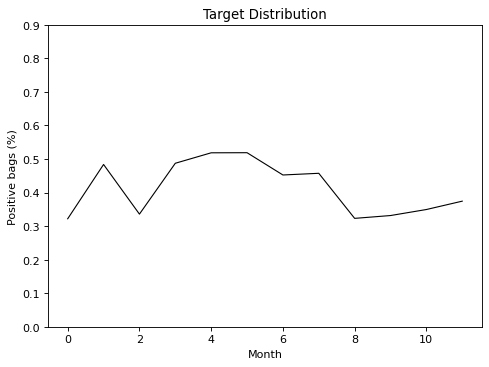

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), dpi=80)

plt.plot(target_distributions_month, lw=1, color='black')
axs.set(xlabel='Month', ylabel='Positive bags (%)', title='Target Distribution', yticks=np.arange(0,1, 0.1))

## Loop months: N-1 Train/ N Predict

  9%|███████▌                                                                           | 1/11 [00:45<07:33, 45.38s/it]

AUC = 0.7086263503126673
Recall of 95.00 % reached on 0.428 threshold. This equals a 23.699 % precision


 18%|███████████████                                                                    | 2/11 [01:40<07:41, 51.23s/it]

AUC = 0.7603575284414316
Recall of 95.00 % reached on 0.324 threshold. This equals a 23.989 % precision


 27%|██████████████████████▋                                                            | 3/11 [02:51<08:02, 60.37s/it]

AUC = 0.7166412127382771
Recall of 95.00 % reached on 0.397 threshold. This equals a 27.606 % precision


 36%|██████████████████████████████▏                                                    | 4/11 [03:59<07:21, 63.04s/it]

AUC = 0.7932470316622691
Recall of 95.00 % reached on 0.263 threshold. This equals a 38.522 % precision


 45%|█████████████████████████████████████▋                                             | 5/11 [04:13<04:32, 45.42s/it]

AUC = 0.7516887918787457
Recall of 95.00 % reached on 0.265 threshold. This equals a 31.610 % precision


 55%|█████████████████████████████████████████████▎                                     | 6/11 [05:14<04:14, 50.86s/it]

AUC = 0.7560989494384931
Recall of 95.00 % reached on 0.246 threshold. This equals a 31.858 % precision


 64%|████████████████████████████████████████████████████▊                              | 7/11 [05:50<03:03, 45.94s/it]

AUC = 0.8203369459353047
Recall of 95.00 % reached on 0.284 threshold. This equals a 37.694 % precision


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [06:04<01:47, 35.75s/it]

AUC = 0.8089096601207328
Recall of 95.00 % reached on 0.264 threshold. This equals a 36.695 % precision


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [06:30<01:05, 32.86s/it]

AUC = 0.792524783894418
Recall of 95.00 % reached on 0.430 threshold. This equals a 32.861 % precision


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [07:25<00:39, 39.44s/it]

AUC = 0.7773911026042573
Recall of 95.00 % reached on 0.420 threshold. This equals a 35.828 % precision


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [08:17<00:00, 45.20s/it]

AUC = 0.8126957820354047
Recall of 95.00 % reached on 0.438 threshold. This equals a 43.694 % precision


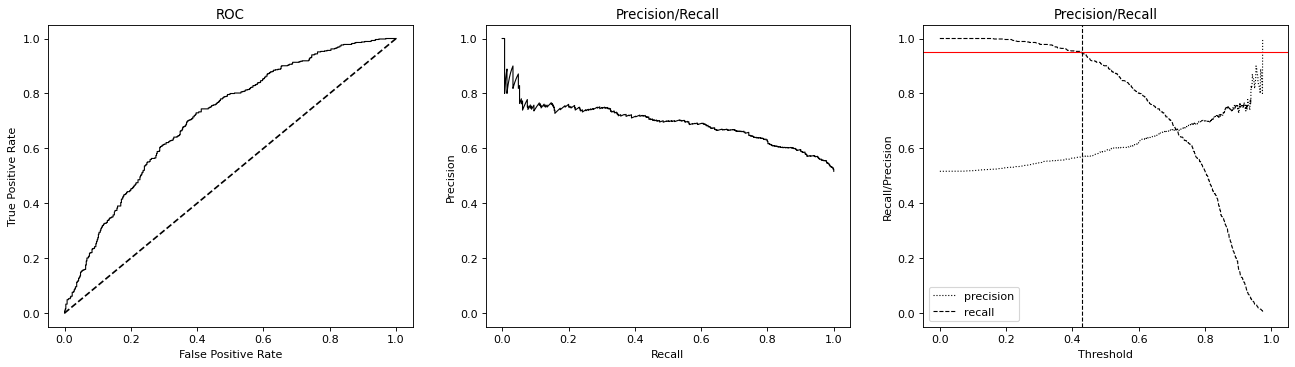

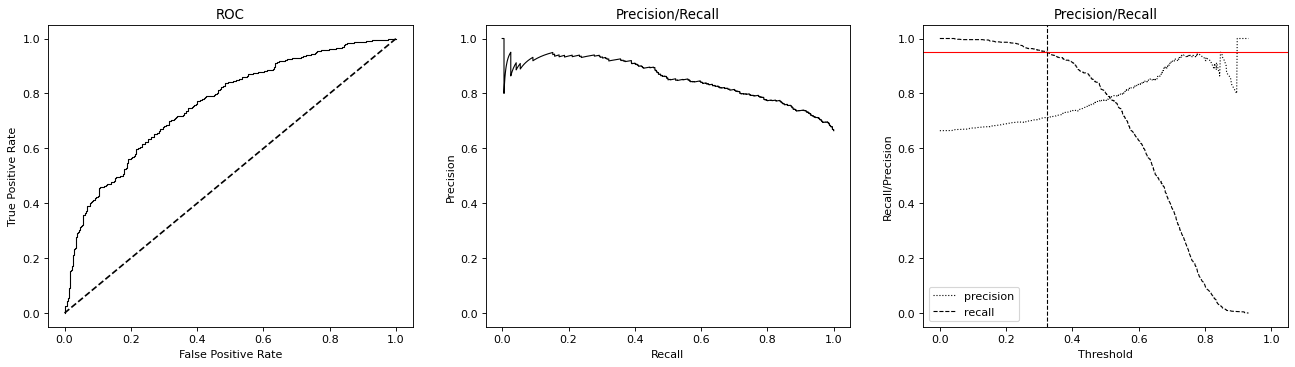

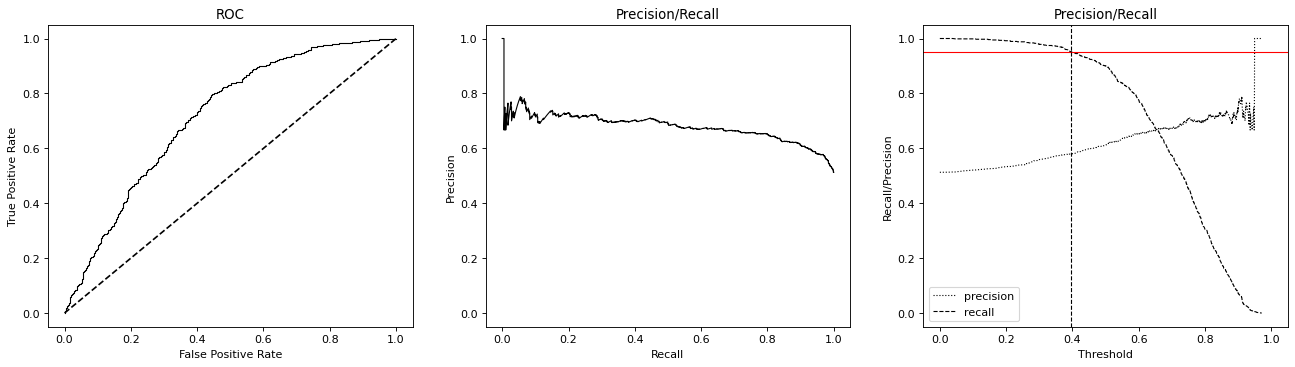

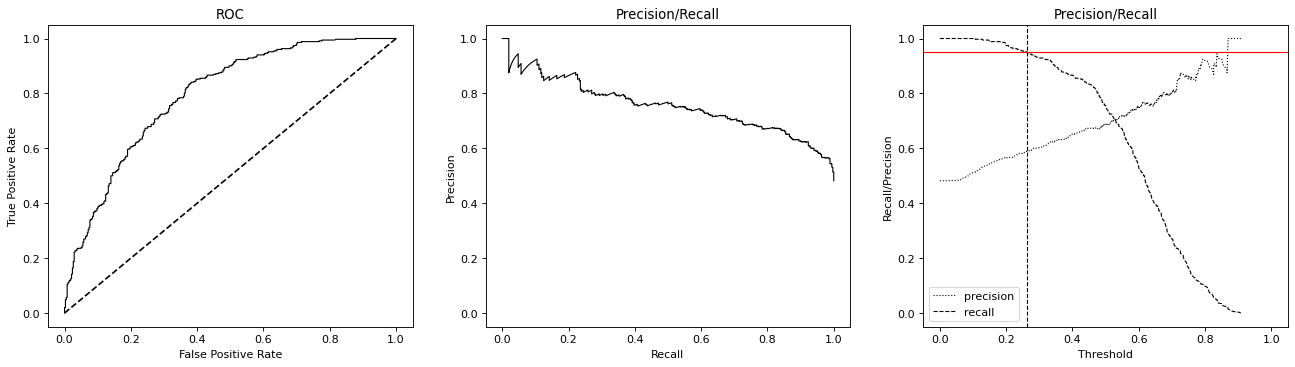

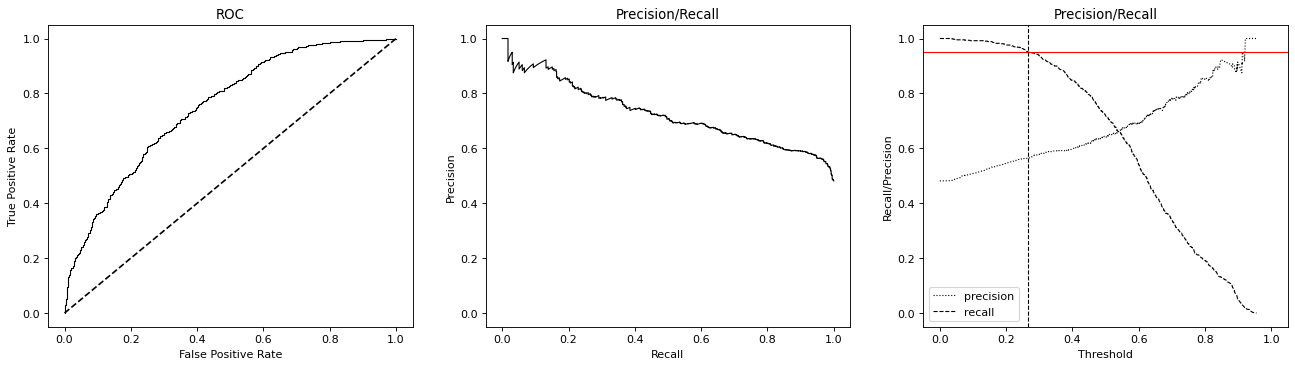

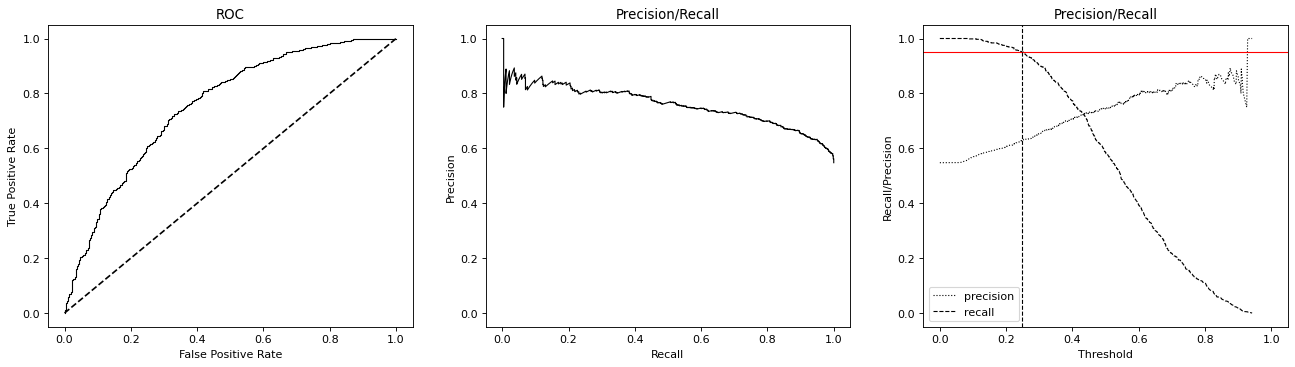

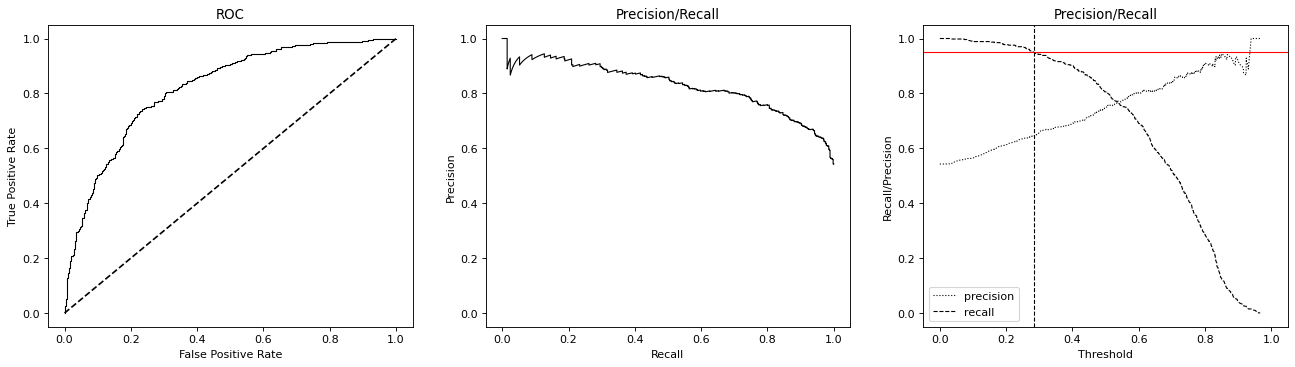

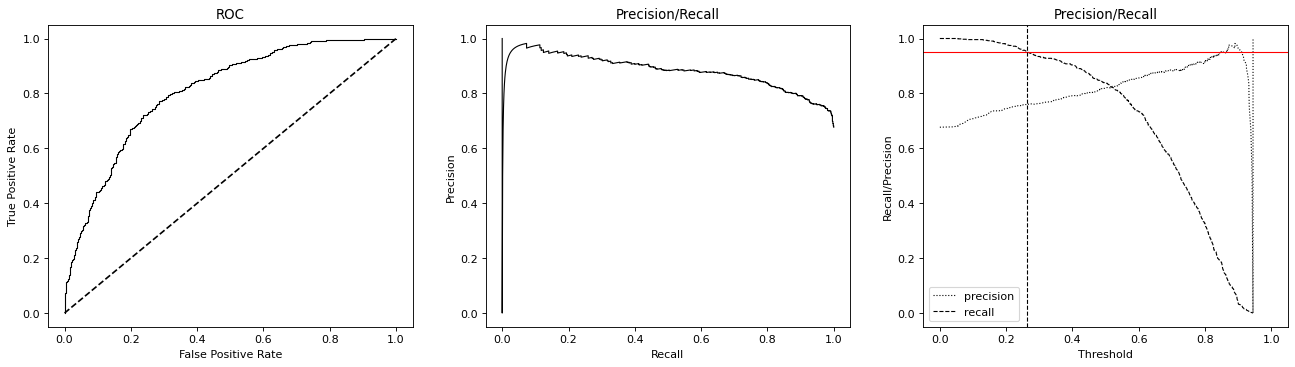

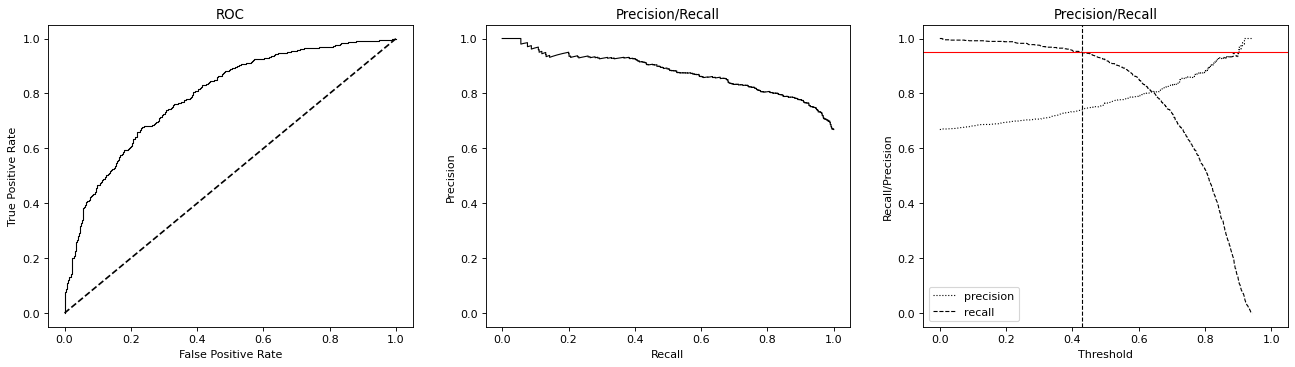

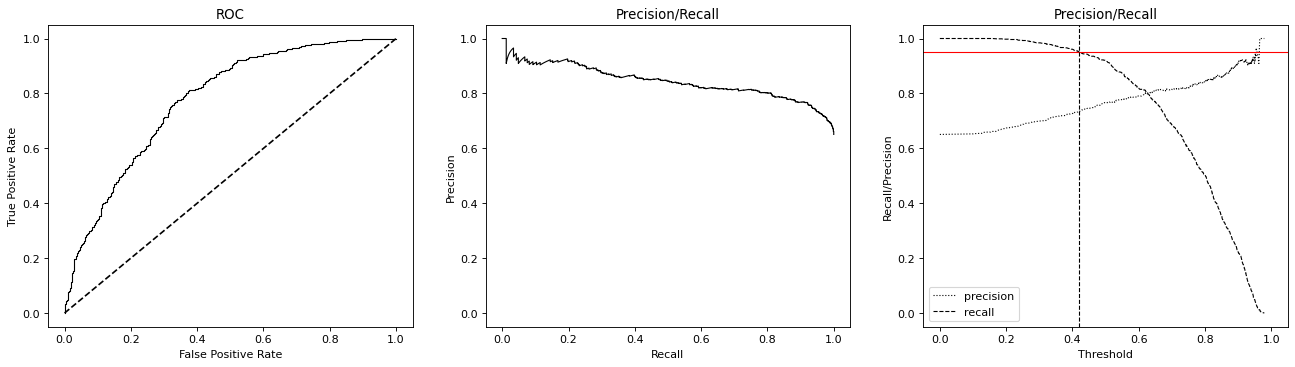

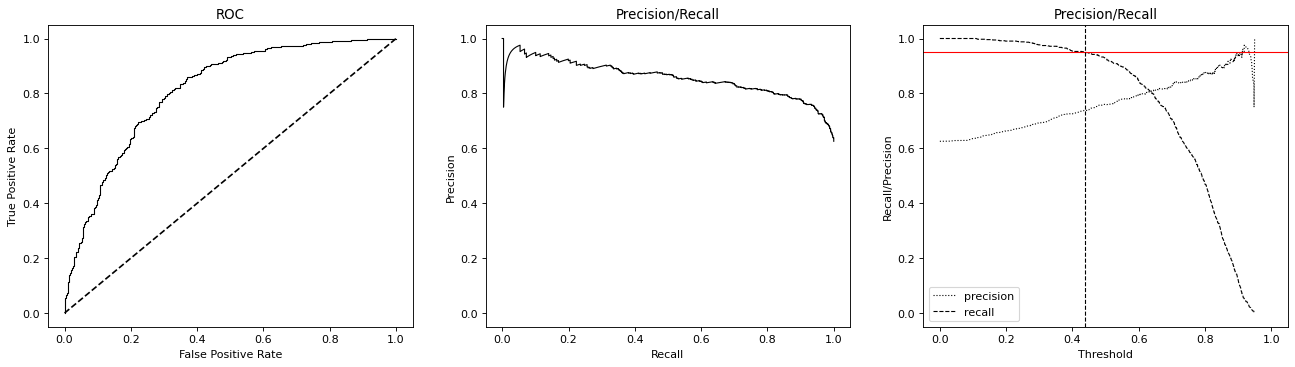

In [14]:
months = range(1, 12)

performance_history = []

for i in tqdm(months):
    bags_month_train = bags_train[invoice_months == i]
    y_round_up_bag_month_train = y_round_up_bag_train[invoice_months == i]

    bags_month_validation = bags_train[invoice_months == i+1]
    y_round_up_bag_month_validation = y_round_up_bag_train[invoice_months == i+1]
    
    pipeline.fit(X=bags_month_train, y=y_round_up_bag_month_train)
    
    y_round_up_bag_month_validation_pred = pd.DataFrame(pipeline.predict_proba(bags_month_validation))
    
    min_threshold, specificity, auc = model_evaluation(y_round_up_bag_month_validation, y_round_up_bag_month_validation_pred)
    
    performance_history += [[min_threshold, specificity, auc]]

In [46]:
performance_history_threshold = [i[0] for i in performance_history]
performance_history_specificity = [i[1] for i in performance_history]
performance_history_auc = [i[2] for i in performance_history]

[Text(0.5, 0, 'Iteration'),
 Text(0, 0.5, 'AUC'),
 Text(0.5, 1.0, 'AUC benchmark per month'),

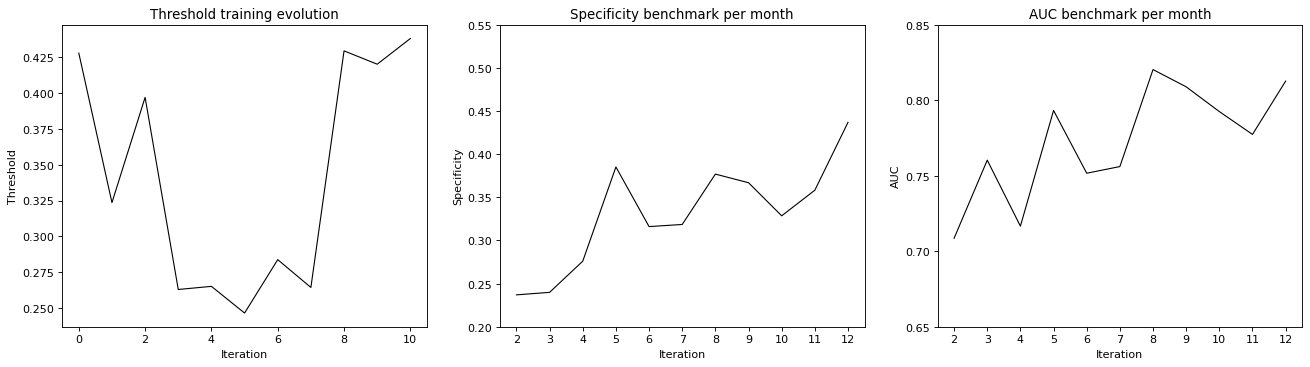

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=80)

axs[0].plot(performance_history_threshold, lw=1, color='black')
axs[0].set(xlabel='Iteration', ylabel='Threshold', title='Threshold training evolution')
axs[1].plot(np.arange(2, 13, 1), performance_history_specificity, lw=1, color='black')
axs[1].set(xlabel='Iteration', ylabel='Specificity', title='Specificity benchmark per month', yticks=np.arange(.2, .6, .05), xticks=np.arange(2, 13, 1))
axs[2].plot(np.arange(2, 13, 1), performance_history_auc, lw=1, color='black')
axs[2].set(xlabel='Iteration', ylabel='AUC', title='AUC benchmark per month', yticks=np.arange(0.65, .9, 0.05), xticks=np.arange(2, 13, 1))

## Loop months: Train/Predict within month

  9%|███████▌                                                                           | 1/11 [00:12<02:07, 12.72s/it]

AUC = 0.8403854210305823
Recall of 95.00 % reached on 0.412 threshold. This equals a 0.484 % precision


 18%|███████████████                                                                    | 2/11 [00:39<03:06, 20.76s/it]

AUC = 0.677101349014182
Recall of 95.00 % reached on 0.251 threshold. This equals a 0.265 % precision


 27%|██████████████████████▋                                                            | 3/11 [01:12<03:32, 26.61s/it]

AUC = 0.756155950752394
Recall of 95.00 % reached on 0.239 threshold. This equals a 0.093 % precision


 36%|██████████████████████████████▏                                                    | 4/11 [01:55<03:51, 33.13s/it]

AUC = 0.7809684684684685
Recall of 95.00 % reached on 0.256 threshold. This equals a 0.347 % precision


 45%|█████████████████████████████████████▋                                             | 5/11 [02:02<02:21, 23.57s/it]

AUC = 0.8005843681519357
Recall of 95.00 % reached on 0.068 threshold. This equals a 0.162 % precision


 55%|█████████████████████████████████████████████▎                                     | 6/11 [02:35<02:14, 26.91s/it]

AUC = 0.7571095571095572
Recall of 95.00 % reached on 0.169 threshold. This equals a 0.167 % precision


 64%|████████████████████████████████████████████████████▊                              | 7/11 [02:49<01:29, 22.46s/it]

AUC = 0.739577972207926
Recall of 95.00 % reached on 0.279 threshold. This equals a 0.207 % precision


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [02:56<00:53, 17.68s/it]

AUC = 0.8448979591836735
Recall of 95.00 % reached on 0.179 threshold. This equals a 0.429 % precision


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [03:08<00:32, 16.04s/it]

AUC = 0.7663299663299663
Recall of 95.00 % reached on 0.443 threshold. This equals a 0.356 % precision


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [03:36<00:19, 19.71s/it]

AUC = 0.883110060415025
Recall of 95.00 % reached on 0.467 threshold. This equals a 0.426 % precision


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:05<00:00, 22.28s/it]

AUC = 0.8344068706387546
Recall of 95.00 % reached on 0.288 threshold. This equals a 0.391 % precision


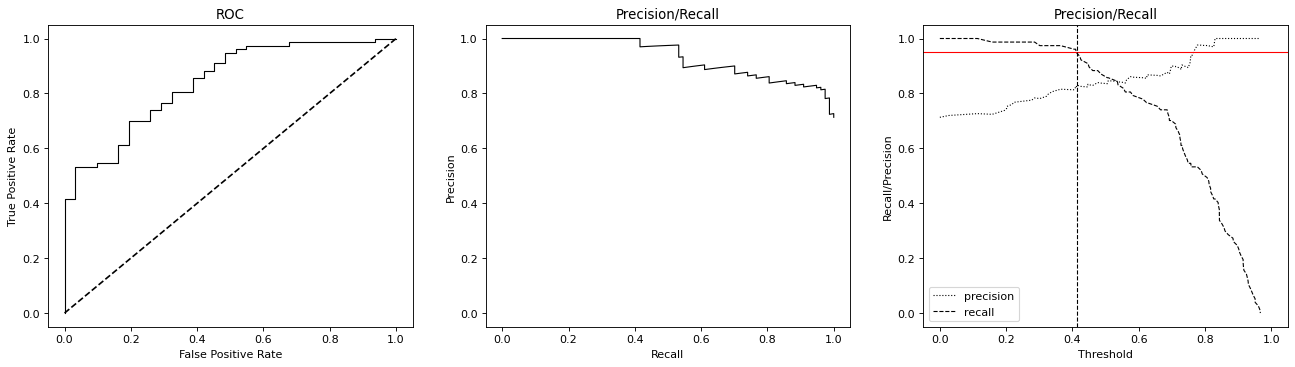

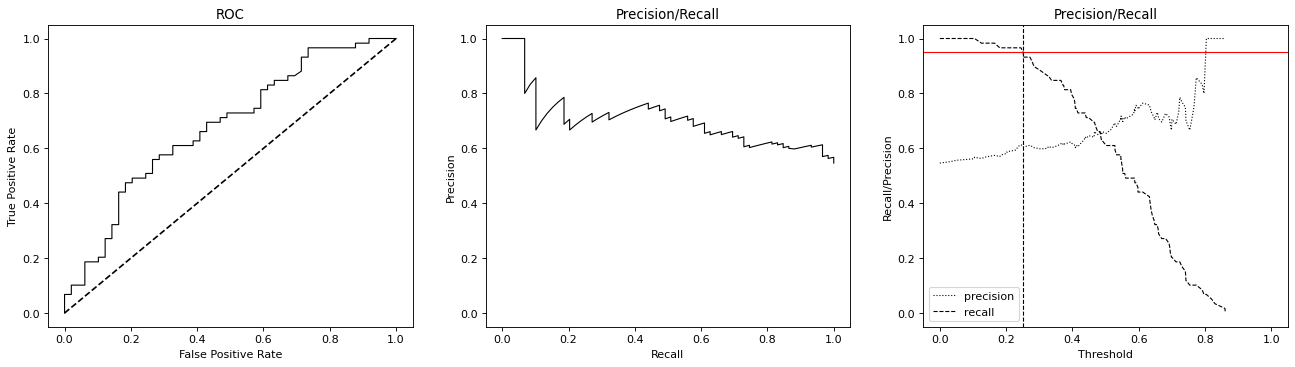

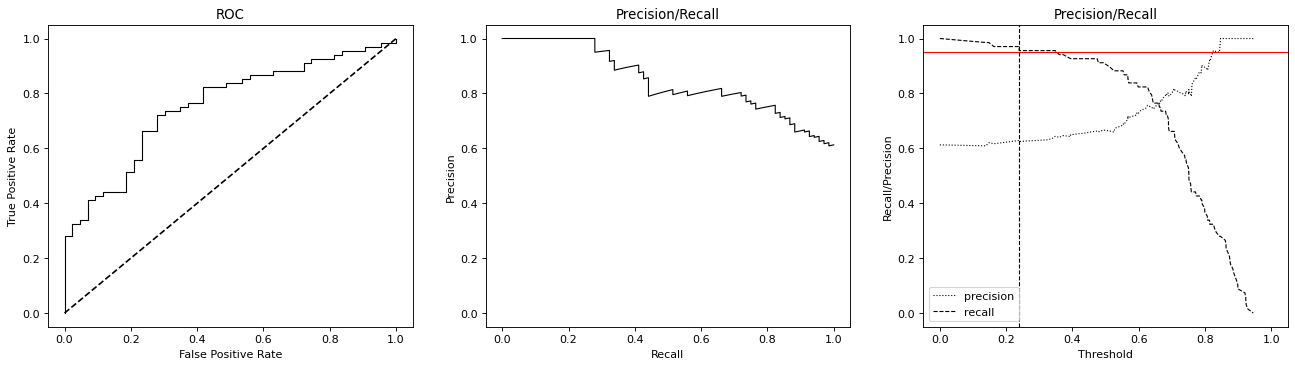

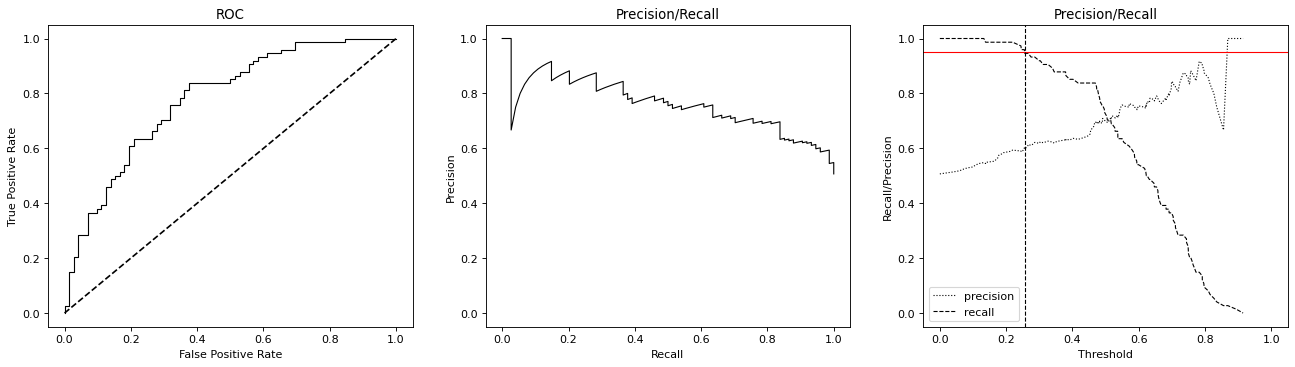

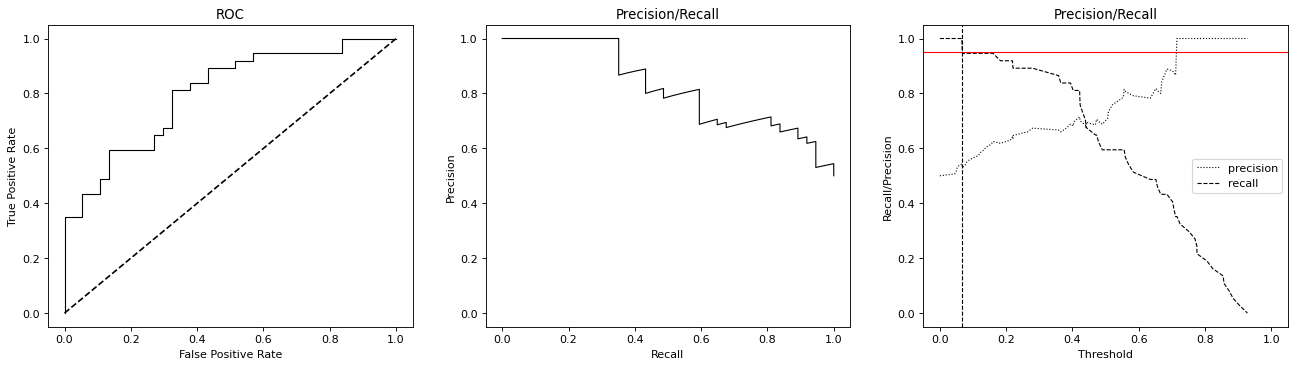

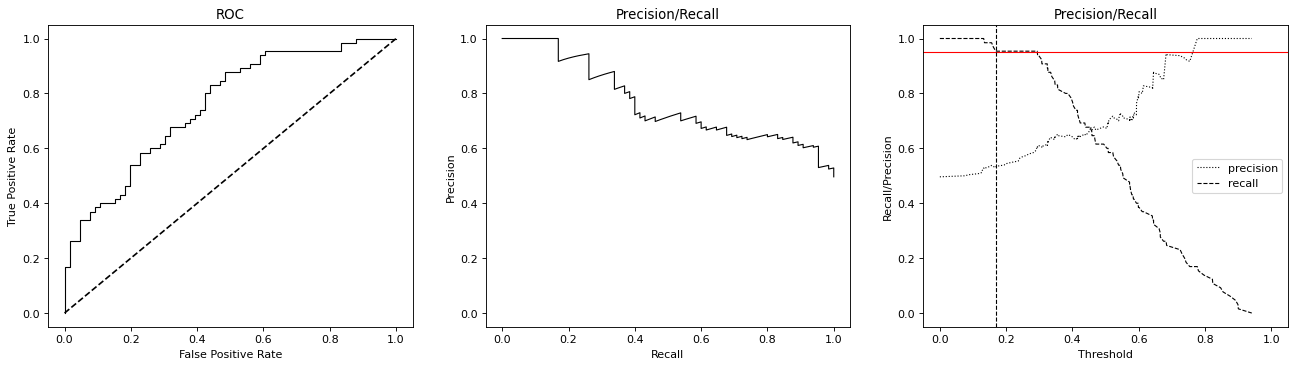

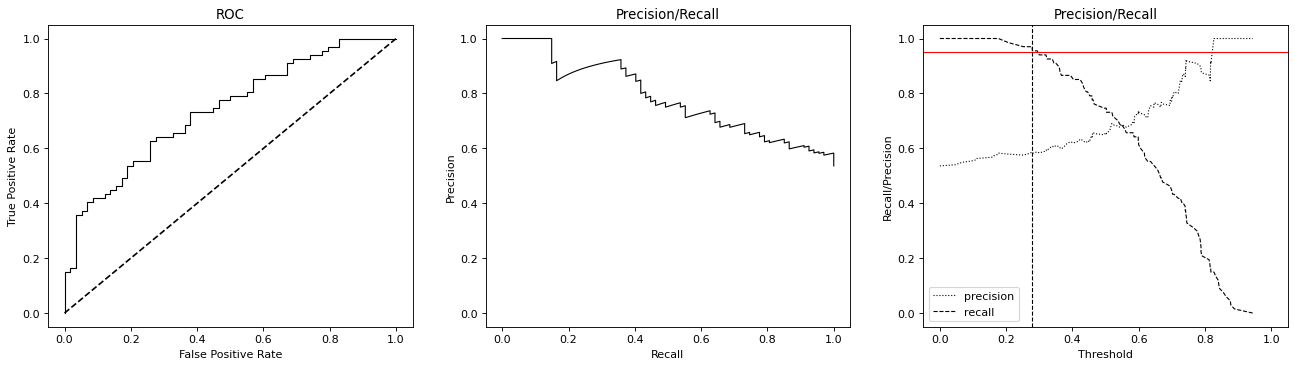

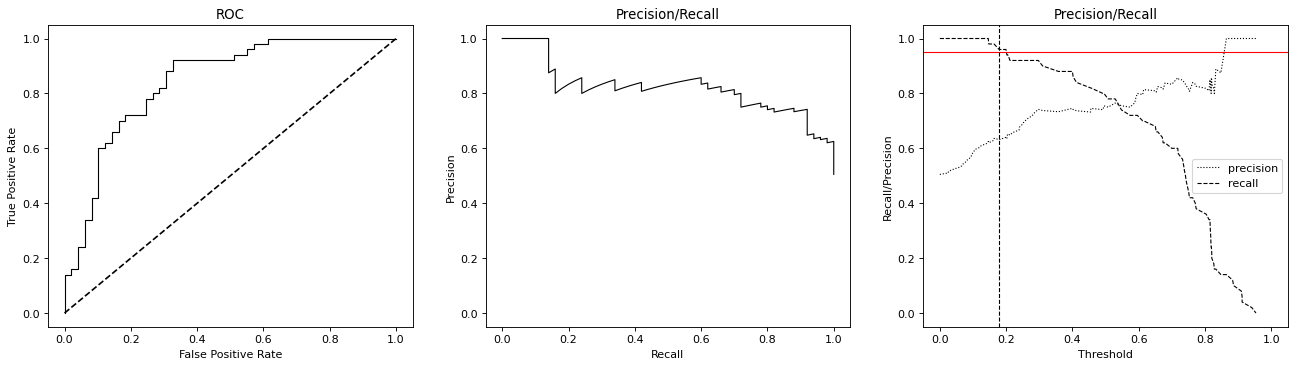

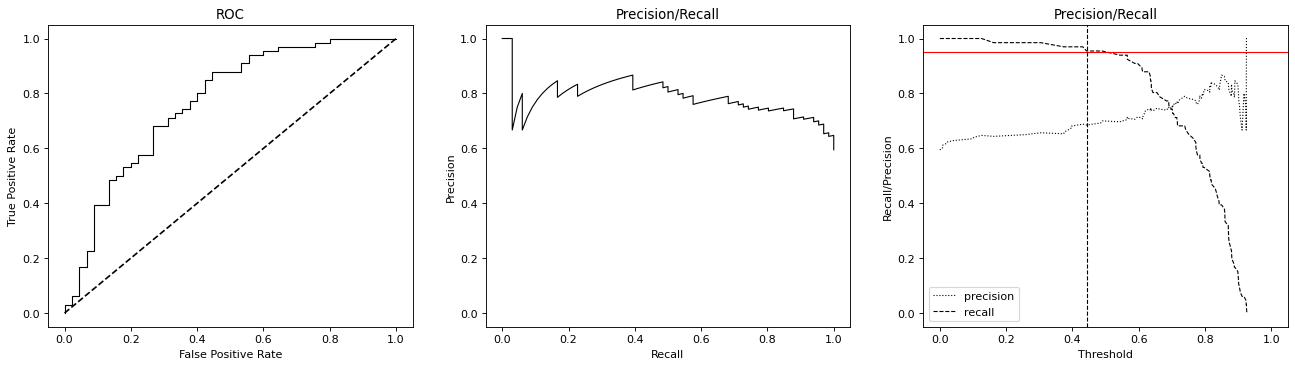

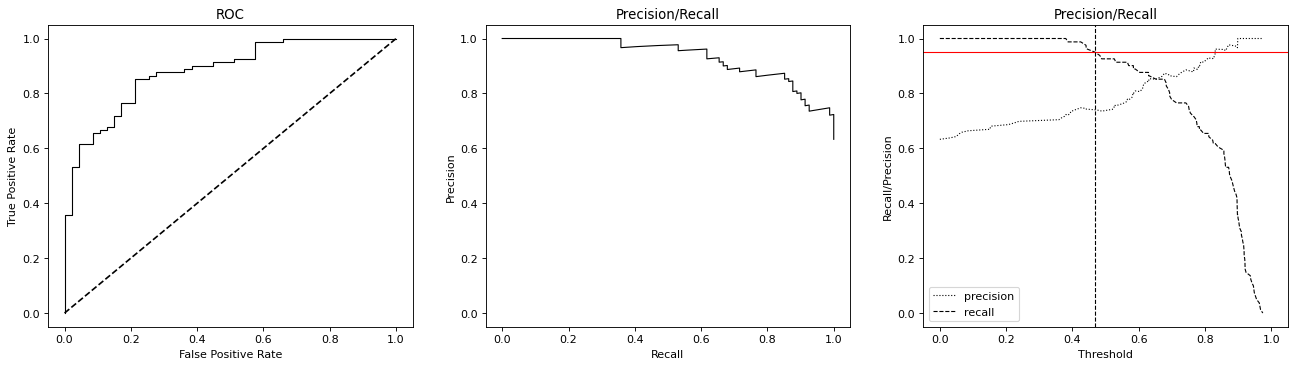

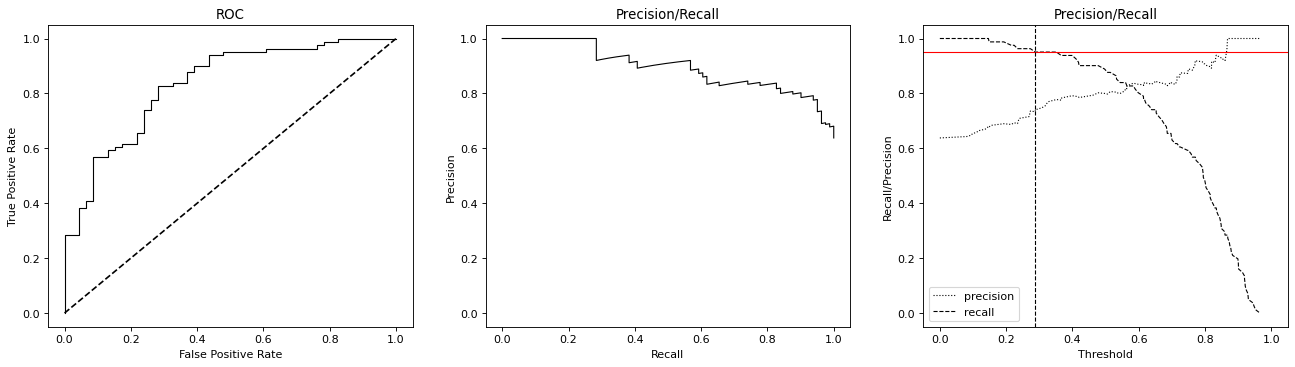

In [69]:
from sklearn.model_selection import train_test_split

months = range(1, 12)

performance_history = []

for i in tqdm(months):
    bags_month_train, bags_month_validation, y_round_up_bag_month_train, y_round_up_bag_month_validation = train_test_split(bags_train[invoice_months == i], y_round_up_bag_train[invoice_months == i], train_size=.9)

    pipeline.fit(X=bags_month_train, y=y_round_up_bag_month_train)
    
    y_round_up_bag_month_validation_pred = pd.DataFrame(pipeline.predict_proba(bags_month_validation))
    
    min_threshold, specificity, auc = model_evaluation(y_round_up_bag_month_validation, y_round_up_bag_month_validation_pred)
    
    performance_history += [[min_threshold, specificity, auc]]

In [70]:
performance_history_threshold = [i[0] for i in performance_history]
performance_history_specificity = [i[1] for i in performance_history]
performance_history_auc = [i[2] for i in performance_history]

[Text(0.5, 0, 'Iteration'),
 Text(0, 0.5, 'AUC'),
 Text(0.5, 1.0, 'AUC benchmark per month'),

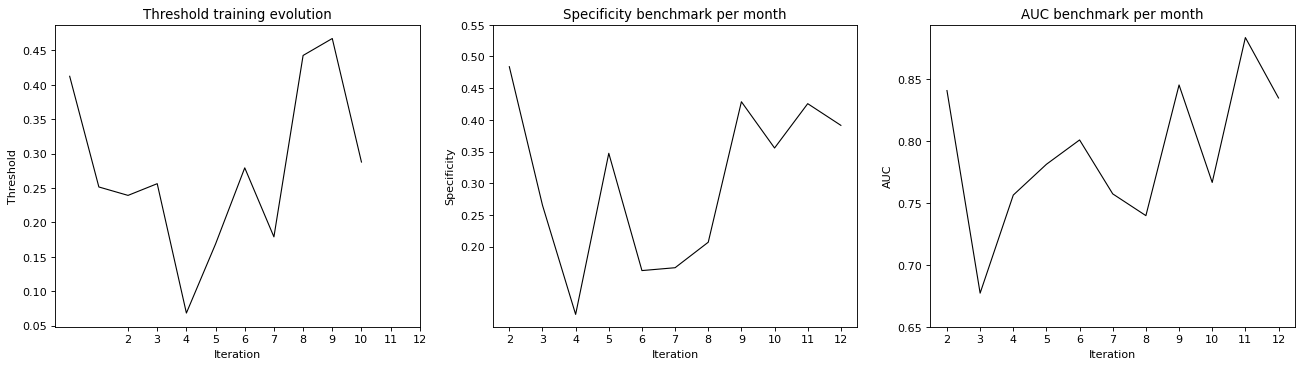

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=80)

axs[0].plot(performance_history_threshold, lw=1, color='black')
axs[0].set(xlabel='Iteration', ylabel='Threshold', title='Threshold training evolution', xticks=np.arange(2, 13, 1))
axs[1].plot(np.arange(2, 13, 1), performance_history_specificity, lw=1, color='black')
axs[1].set(xlabel='Iteration', ylabel='Specificity', title='Specificity benchmark per month', yticks=np.arange(.2, .6, .05), xticks=np.arange(2, 13, 1))
axs[2].plot(np.arange(2, 13, 1), performance_history_auc, lw=1, color='black')
axs[2].set(xlabel='Iteration', ylabel='AUC', title='AUC benchmark per month', yticks=np.arange(0.65, .9, 0.05), xticks=np.arange(2, 13, 1))

[Text(0.5, 0, 'Iteration'),
 Text(0, 0.5, 'AUC'),
 Text(0.5, 1.0, 'AUC benchmark per month'),

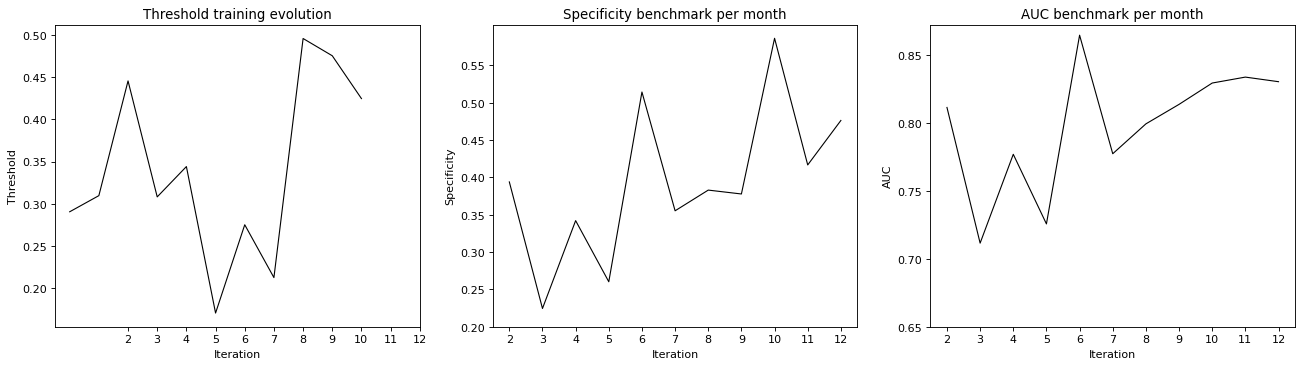

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=80)

axs[0].plot(performance_history_threshold, lw=1, color='black')
axs[0].set(xlabel='Iteration', ylabel='Threshold', title='Threshold training evolution', xticks=np.arange(2, 13, 1))
axs[1].plot(np.arange(2, 13, 1), performance_history_specificity, lw=1, color='black')
axs[1].set(xlabel='Iteration', ylabel='Specificity', title='Specificity benchmark per month', yticks=np.arange(.2, .6, .05), xticks=np.arange(2, 13, 1))
axs[2].plot(np.arange(2, 13, 1), performance_history_auc, lw=1, color='black')
axs[2].set(xlabel='Iteration', ylabel='AUC', title='AUC benchmark per month', yticks=np.arange(0.65, .9, 0.05), xticks=np.arange(2, 13, 1))

In [68]:
performance_history_specificity

[0.3939393939393939,
 0.22448979591836735,
 0.34210526315789475,
 0.2602739726027397,
 0.5142857142857142,
 0.35526315789473684,
 0.3829787234042553,
 0.37777777777777777,
 0.5862068965517241,
 0.4166666666666667,
 0.47619047619047616]

In [67]:
performance_history_auc

[0.8113131313131313,
 0.7115185057073676,
 0.7768565248738284,
 0.7256520923250139,
 0.8644688644688644,
 0.7772727272727272,
 0.7992362247681397,
 0.8135802469135802,
 0.8292682926829269,
 0.8336352657004832,
 0.8302521008403362]

In [37]:
raise(Exception('Stop'))

Exception: Stop

# Admin queries

In [ ]:
from admin import admin_sql

cnxn_admin_sql = admin_sql.AdminSql(r'C:\Users\Ward.RFN\Downloads\credentials\AdminSQL_Credentials_Production.json')

df = cnxn_admin_sql.sql_query('''
                                SELECT i.INVOICE_NR, i.INVOICE_DATE, ild.*
                                FROM DBA.INVOICE i
                                LEFT JOIN DBA.INVOICE_LINES ild ON i.INVOICE_ID = ild.INVOICE_ID
                                WHERE i.INVOICE_ID = '589271' ''')
df.head()

In [ ]:
589271

# Search CustomerId via InvoiceNR

In [ ]:
from admin import admin_sql
invoice_nr = 2207804
print('Invoice nr = {}'.format(invoice_nr))
cnxn_sql = admin_sql.AdminSql(r'C:\Users\Ward.RFN\Downloads\credentials\AdminSQL_Credentials_Production.json')
print('Customer Id = {}'.format(cnxn_sql.sql_query('SELECT CUSTOMER_ID FROM DBA.INVOICE WHERE INVOICE_NR = \'{}\''.format(invoice_nr))['CUSTOMER_ID'].iloc[0]))